In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

import shap

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb


from sklearn.metrics import make_scorer ,mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error

from scipy.stats import skew

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate , cross_val_score

In [14]:
data_with_smiles=pd.read_csv("data\jjapac4894supp2.csv")
data=pd.read_csv("data\jjapac4894supp1.csv")

In [15]:
data.head()

,Paper No.,PCE max (%),VOC (V),JSC (mA/cm2),FF (%),"For VOC, JSC and FF, when only average values were available instead of actual values of the best devices, the average values were listed. These data were mainly obtained from tables and the main text of articles. Some data were from the supplymentary materials."
0,3,9.48,0.93,15.92,63.9,NaN
1,3,7.02,0.99,12.66,56.3,NaN
2,3,8.31,0.90,14.07,66.0,NaN
3,3,6.46,0.93,12.53,55.5,NaN
4,4,14.70,0.91,21.50,75.0,NaN


In [16]:
data=data.drop([data.columns[-1],data.columns[0]],axis=1)

In [17]:
data

,PCE max (%),VOC (V),JSC (mA/cm2),FF (%)
0,9.48,0.93,15.92,63.9
1,7.02,0.99,12.66,56.3
2,8.31,0.90,14.07,66.0
3,6.46,0.93,12.53,55.5
4,14.70,0.91,21.50,75.0
...,...,...,...,...
1351,1.76,1.15,4.51,34.0
1352,0.54,0.92,1.49,39.8
1353,0.23,0.74,0.85,37.3
1354,0.28,1.06,0.68,38.4


# DATA PREPROCESSING

In [18]:
data.describe()

,PCE max (%),VOC (V),JSC (mA/cm2),FF (%)
count,1356.000000,1356.000000,1356.000000,1355.000000
mean,7.260537,0.905183,13.550871,57.420951
std,3.714272,0.487485,5.886450,12.244684
min,0.000200,0.020000,0.010000,14.000000
25%,4.500000,0.800000,9.707500,51.000000
50%,7.500000,0.887000,14.400000,59.760000
75%,10.112500,0.946000,17.692500,66.720000
max,16.300000,9.610000,28.900000,86.000000


* Missing Values

In [19]:
print(data.isnull().sum())

PCE max (%)     0
VOC (V)         0
JSC (mA/cm2)    0
FF (%)          1
dtype: int64


In [20]:
missing_ff_row = data[data['FF (%)'].isnull()]
print(missing_ff_row)

     PCE max (%)  VOC (V)  JSC (mA/cm2)  FF (%)
886         10.0     0.94         15.51     NaN


In [21]:
data['FF (%)'].fillna(data['FF (%)'].mean(), inplace=True)
print(data.isnull().sum())

PCE max (%)     0
VOC (V)         0
JSC (mA/cm2)    0
FF (%)          0
dtype: int64


* Outliers

The "min" and "max" rows show that there are some extreme values in the dataset. For example, the maximum VOC value is 9.61 V, which is much higher than the median value of 0.887 V. We can confirm that with an other view

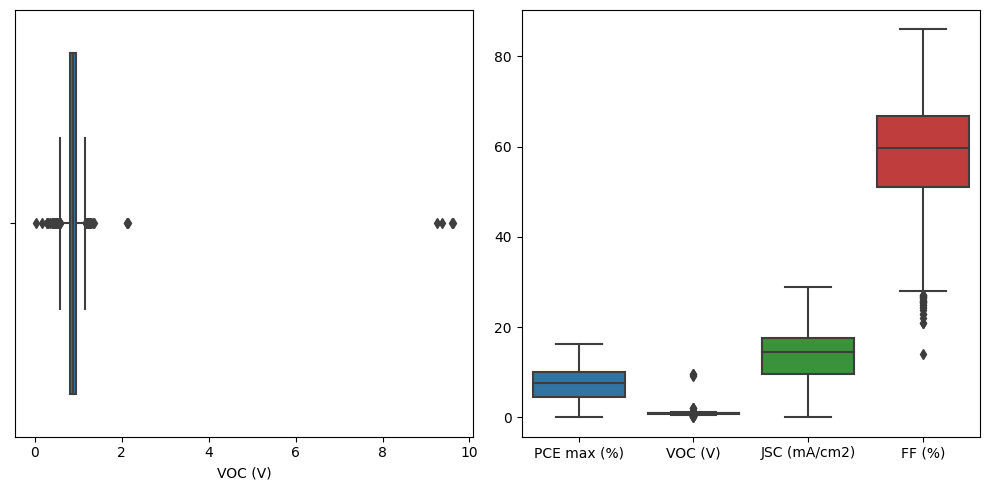

In [22]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.boxplot(x=data['VOC (V)'], ax=axs[0])
sns.boxplot(data=data, ax=axs[1])
plt.tight_layout()
plt.show()

In [23]:
# calculate the skewness coefficient of a variable
skewness = skew(data)
print(skewness) #15.97 >>>> 0

[-0.12607024 15.97199457 -0.2791207  -0.79855473]


In [24]:
#Possible Solution
# Apply a log transformation to the VOC column
data['VOC (V)'] = data['VOC (V)'] + 1
data['VOC (V)'] = np.log(data['VOC (V)'])

data.describe()

,PCE max (%),VOC (V),JSC (mA/cm2),FF (%)
count,1356.000000,1356.000000,1356.000000,1356.000000
mean,7.260537,0.633318,13.550871,57.420951
std,3.714272,0.121066,5.886450,12.240165
min,0.000200,0.019803,0.010000,14.000000
25%,4.500000,0.587787,9.707500,51.000000
50%,7.500000,0.634988,14.400000,59.730000
75%,10.112500,0.665776,17.692500,66.710000
max,16.300000,2.361797,28.900000,86.000000


* Standardization 

Because of differents values's scale  

In [25]:
# Create a StandardScalerobject , fit and transfrom data
scaler = StandardScaler()
X=data.drop(["PCE max (%)"],axis=1)
y=data["PCE max (%)"]
scaler.fit(X)
X_scaled = scaler.transform(X)
data_scaled = pd.DataFrame(X_scaled, columns=X.columns)
data_scaled["PCE max (%)"] = y

In [26]:
data_scaled.describe()

,VOC (V),JSC (mA/cm2),FF (%),PCE max (%)
count,1.356000e+03,1.356000e+03,1.356000e+03,1356.000000
mean,2.301502e-16,1.539247e-17,2.421244e-16,7.260537
std,1.000369e+00,1.000369e+00,1.000369e+00,3.714272
min,-5.069461e+00,-2.301195e+00,-3.548724e+00,0.000200
25%,-3.762215e-01,-6.531592e-01,-5.247739e-01,4.500000
50%,1.380431e-02,1.443046e-01,1.887149e-01,7.500000
75%,2.682025e-01,7.038464e-01,7.591790e-01,10.112500
max,1.428239e+01,2.608498e+00,2.335720e+00,16.300000


<AxesSubplot:>

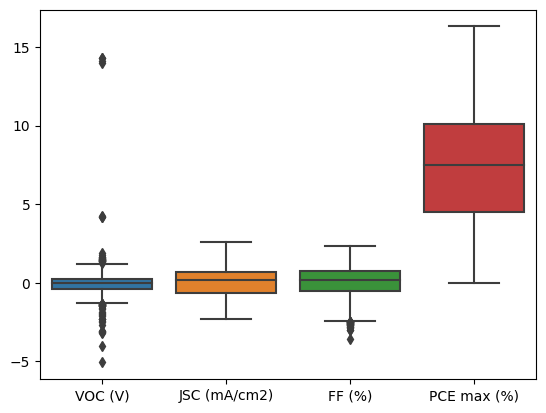

In [27]:
sns.boxplot(data=data_scaled)

* Distribution of reported PCE
* Schematics of expressions of somes molecules

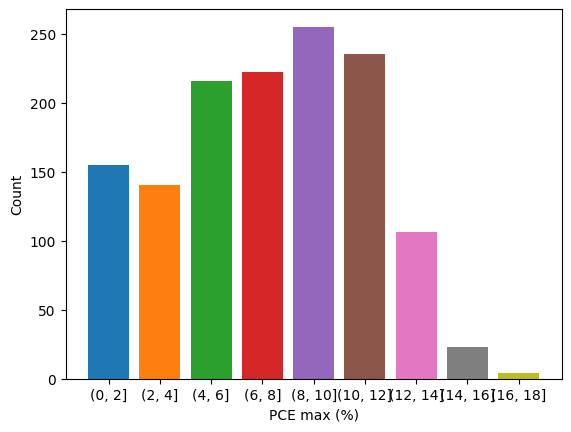

In [28]:
data['pce_pair'] = pd.cut(data['PCE max (%)'], bins=[0, 2, 4, 6, 8, 10,12, 14, 16 , 18])
pce_count = data.groupby('pce_pair').size()

colors = plt.cm.tab10(np.arange(len(pce_count)))

plt.bar(pce_count.index.astype(str), pce_count.values, color=colors)
plt.xlabel('PCE max (%)')
plt.ylabel('Count')
plt.show()


O=C1C2=C(C=CC=C2)C(/C1=C/C3=CC(C4(C5=CC=C(CCCCCC)C=C5)C6=CC=C(CCCCCC)C=C6)=C(S3)C7=C4C=C(C(SC(/C=C8/C(C(C=CC=C9)=C9C8=O)=C(C#N)\C#N)=C%10)=C%10C%11(C%12=CC=C(CCCCCC)C=C%12)C%13=CC=C(CCCCCC)C=C%13)C%11=C7)=C(C#N)/C#N


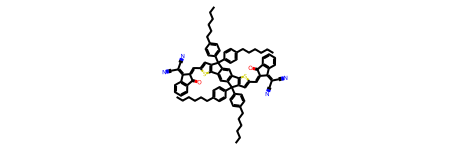

In [29]:
print(data_with_smiles['A SMILES'][0])
Chem.MolFromSmiles(data_with_smiles['A SMILES'][0])

* Check all the useful information that we may have missed

In [30]:
profile = ProfileReport(
    data_scaled,
    title="Profiling Report For D-NFA dataset ",
    html={'style':{'full_width':True}}
)

profile.to_file(output_file = "data_NFA-profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

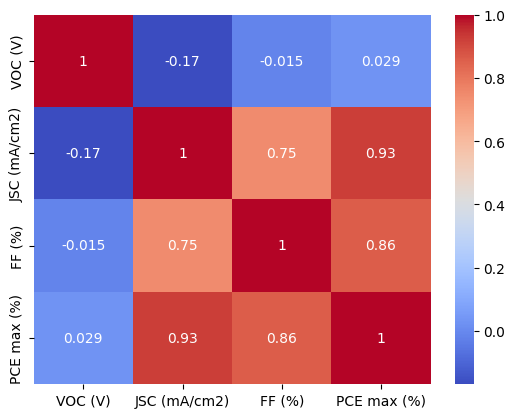

In [31]:
# We can also find the Correlation Matrix in our profile report , but this plot are simply more easier to interpret 
corr_matrix = data_scaled.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.show()

Feature importance using SHAP values based on

* XGBoost
* Random Forest
* Desicion Trees
* K-nearest neighbors

We don't have many descriptors so we SHAP Values will only based on Xgb and RF 

In [32]:
X=data_scaled.drop(["PCE max (%)"],axis=1)
y=data_scaled["PCE max (%)"]

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


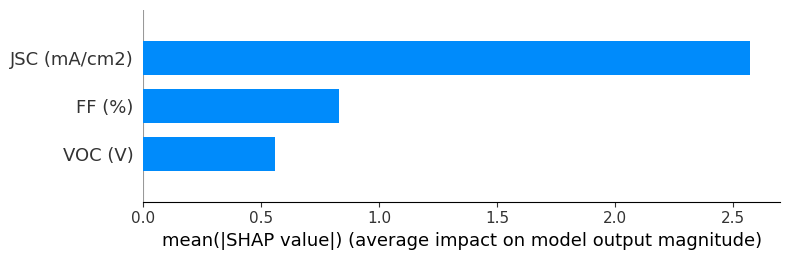

In [33]:
# With XGBOOST
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X, y)

explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.summary_plot(shap_values, X, plot_type='bar', show=False)

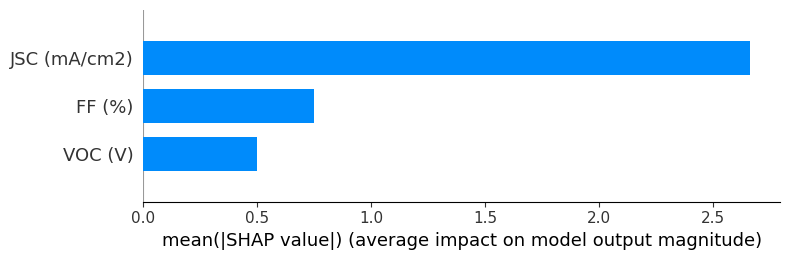

In [34]:
# # With Random Forest 
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.summary_plot(shap_values, X, plot_type='bar', show=False)


Note :These graphs will only help us for our analysis, not for feature selection (because we don't have many descriptors).

# Model Construction 

To select the appropriate regression model , we must train and validate differents models on our train/validation data and compare the metrics

* XGBoost
* Random Forest
* Desicion Trees
* K-nearest neighbors

In [35]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
def train_validate_models_results(X_train, y_train, X_validation, y_validation, models, metrics):
    results = []
    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_validation)
        row = [name]
        for metric_name, metric_func in metrics.items():
            metric_value = metric_func(y_validation, y_pred)
            row.append(metric_value)
        results.append(row)
    df_results = pd.DataFrame(results, columns=['Model'] + list(metrics.keys()))
    return df_results



models = [
    ('Decision Tree Regressor', DecisionTreeRegressor(random_state=42)),
    ('Random Forest Regressor', RandomForestRegressor(random_state=42)),
    ('KNN Regressor', KNeighborsRegressor()),
    ('XGBoost', xgb.XGBRegressor(random_state=42))
]


metrics = {
    'RMSE': mean_squared_error,
    'MAE': mean_absolute_error,
    'R^2': r2_score
}


df=train_validate_models_results(X_train, y_train, X_validation, y_validation, models, metrics)


In [39]:
df

,Model,RMSE,MAE,R^2
0,Decision Tree Regressor,0.591372,0.453639,0.956136
1,Random Forest Regressor,0.320593,0.300325,0.976221
2,KNN Regressor,0.377684,0.264946,0.971986
3,XGBoost,0.195496,0.282467,0.985500


In [40]:
def train_validate_models_results_cv(X, y, models, metrics, cv):
    results = []
    for model_name, model in models :
        row = [model_name]
        for metric_name, metric_func in metrics.items():
            scores = cross_val_score(model, X, y, cv=cv, scoring=metric_func)
            mean_score = np.mean(scores)
            row.append(mean_score)
        results.append(row)
    df_results = pd.DataFrame(results, columns=['Model'] + list(metrics.keys()))
    return df_results

models = [
    ('Decision Tree Regressor', DecisionTreeRegressor(random_state=42)),
    ('Random Forest Regressor', RandomForestRegressor(random_state=42)),
    ('KNN Regressor', KNeighborsRegressor()),
    ('XGBoost', xgb.XGBRegressor(random_state=42))
]


metrics = {
    'RMSE': make_scorer(mean_squared_error, squared=False),
    'MAE': make_scorer(mean_absolute_error),
    'R2': make_scorer(r2_score),
    'Max Error': make_scorer(max_error)
}


df_cv5=train_validate_models_results_cv(X, y, models, metrics,cv=5)


In [41]:
df_cv5

,Model,RMSE,MAE,R2,Max Error
0,Decision Tree Regressor,0.667973,0.410664,0.960071,4.298000
1,Random Forest Regressor,0.536863,0.266362,0.972032,4.323650
2,KNN Regressor,0.444532,0.260485,0.982451,3.359600
3,XGBoost,0.464790,0.250636,0.980194,3.802683


In [42]:
def plot_models_metrics(df , title):
    df_melted = pd.melt(df, id_vars=['Model'], var_name='metric', value_name='value')
    sns.catplot(x="Model", y="value", hue="metric", data=df_melted, kind="bar", height=6, aspect=2)
    plt.ylim(0, 5)
    plt.title(title)
    plt.show()


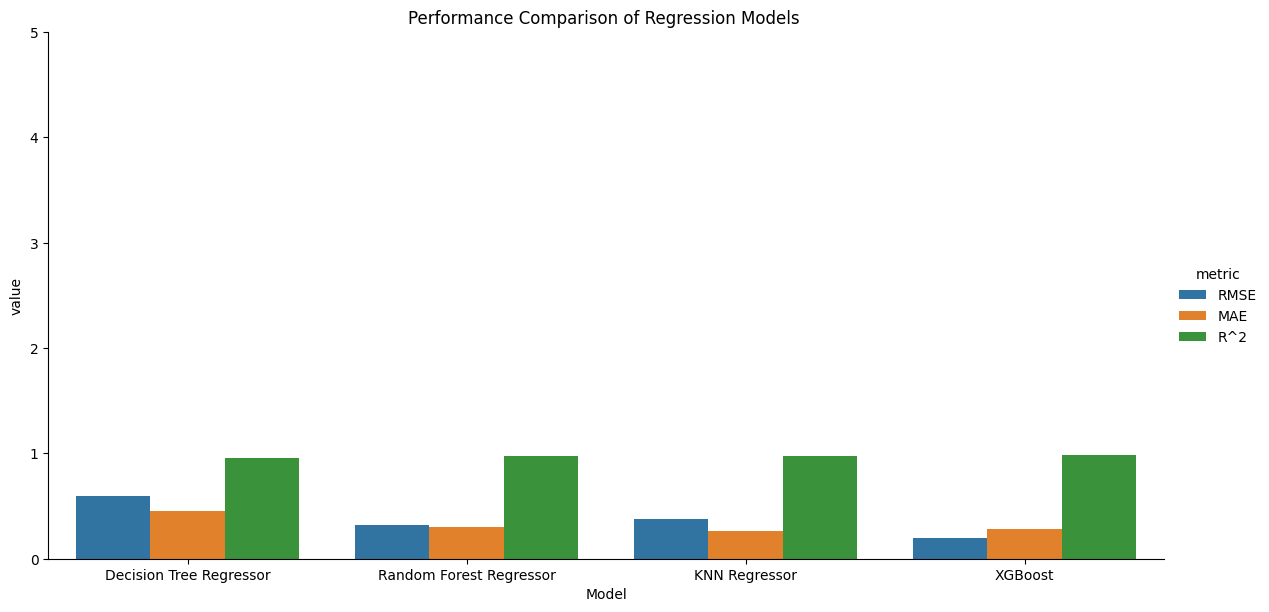

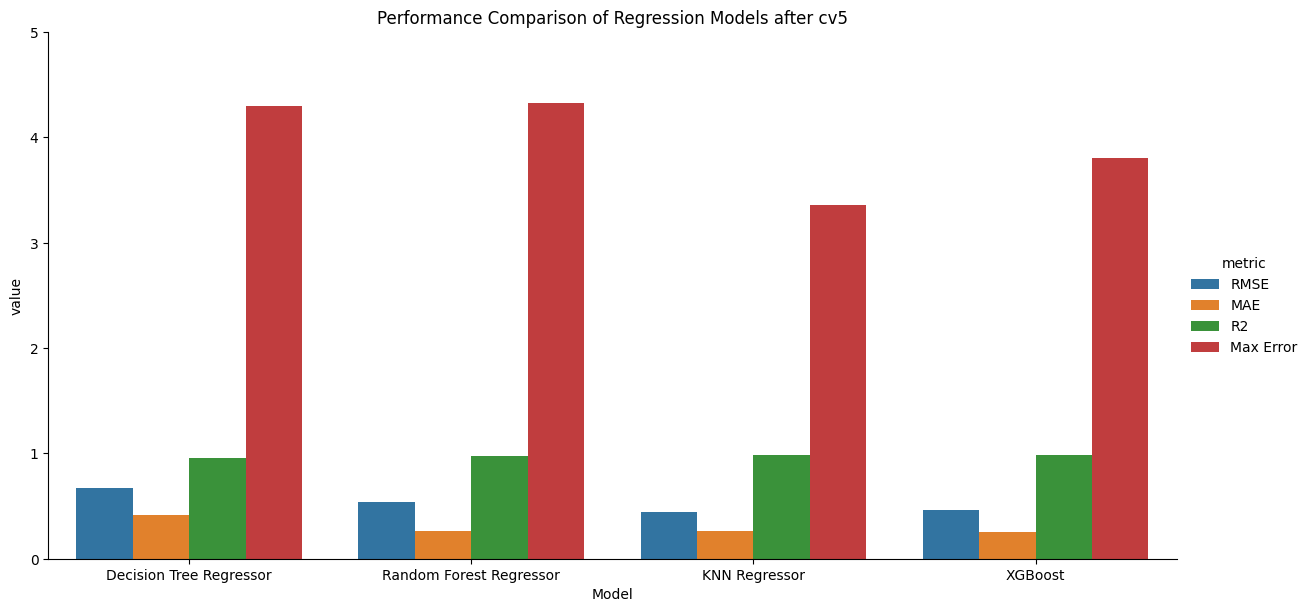

In [43]:
plot_models_metrics(df,title="Performance Comparison of Regression Models ")
plot_models_metrics(df_cv5,title="Performance Comparison of Regression Models after cv5")


We can see that XGBOOST model with default parameters achieves best result with R^2 = 0.985500

# MODEL TEST

Dataset of 200 unique D:A combinations with corresponding PCE manually collected from the literature .
We will use that as new D-NFA comninaisons 

In [503]:
test=pd.read_csv("data\Pseudo_test_data.csv" , sep = ";")


In [504]:
test=test.drop([test.columns[-1],test.columns[0]],axis=1)
new_columns = {'Jsc(mA/cm2)': 'JSC (mA/cm2)', 'Voc(V)': 'VOC (V)','FF': 'FF (%)', 'PCE(%)': 'PCE max (%)'}

test = test.rename(columns=new_columns)
test['FF (%)']=test['FF (%)']*100
test[30:40]

,Donor,Acceptor,JSC (mA/cm2),VOC (V),FF (%),PCE max (%)
30,PM6,Y6,25.50,0.825,72.00,15.00
31,J52,BTA3,14.62,1.070,60.34,9.41
32,J52-Cl,BTA3,13.16,1.240,66.62,10.50
33,PDCBT-2F,IT-M,10.30,1.130,55.00,6.40
34,PTB7-Th,IEICO,13.30,0.900,60.00,7.20
35,PBQ-QF,IEICO-4F,22.40,0.740,64.00,10.50
36,PvBDTTAZ,O-IDTBR,16.20,1.080,65.00,11.40
37,PBDB-T,NCBDT,18.64,0.847,64.60,10.19
38,PTPD3T,ITIC,13.50,0.910,68.00,8.40
39,PTPD2T,ITIC,12.30,0.960,60.00,7.00


In [505]:
test.describe()

,JSC (mA/cm2),VOC (V),FF (%),PCE max (%)
count,200.000000,200.000000,200.000000,200.000000
mean,17.368050,0.903730,63.053150,9.890750
std,4.385205,0.112746,8.481698,3.086631
min,7.900000,0.660000,42.200000,4.100000
25%,14.250000,0.839750,57.400000,7.790000
50%,17.075000,0.890000,63.880000,9.600000
75%,20.425000,0.957750,69.450000,11.805000
max,27.700000,1.340000,81.500000,18.320000


In [506]:
X

,VOC (V),JSC (mA/cm2),FF (%)
0,0.154838,0.402620,0.529522
1,0.275685,-0.151399,-0.091613
2,0.063853,0.088223,0.701152
3,0.154838,-0.173491,-0.156996
4,0.097530,1.350909,1.436707
...,...,...,...
1351,0.440054,-1.536445,-1.914157
1352,0.127667,-2.049677,-1.440132
1353,NaN,-2.158441,-1.644453
1354,0.364813,-2.187332,-1.554552


In [507]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from xgboost import XGBRegressor

def import_data():
    data=pd.read_csv("data\jjapac4894supp1.csv")
    data=data.drop([data.columns[-1],data.columns[0]],axis=1)
    X=data.drop(["PCE max (%)"],axis=1)
    y=data["PCE max (%)"]
    return X,y

X_input , y_output = import_data()

def predict(data,X=X_input, y=y_output):
    
    log_transform = FunctionTransformer(lambda x: np.log(x+1))
    data[['VOC (V)']] = log_transform.fit_transform(data[['VOC (V)']])
    
    transformer = ColumnTransformer(
        transformers=[
            ('scaler', StandardScaler(), [0,1,2])#'VOC (V)','JSC (mA/cm2)', 'FF (%)'
        ],
    )

    pipeline = Pipeline(steps=[('preprocessor', transformer), ('regressor', xgb.XGBRegressor())])
    #s=StandardScaler()
    #s.fit(X)
    pipeline.fit(X, y)
    print(data.describe())
    #a=pipeline['preprocessor']
    #a.fit(X)
    data = pipeline['preprocessor'].transform(data)
    data = pd.DataFrame(data, columns=X.columns)
    print(data)
    predictions = pipeline.predict(data)
    return predictions


In [508]:
X_test=test[['VOC (V)','JSC (mA/cm2)', 'FF (%)' ]]
y_test=test["PCE max (%)"]

test["Predicted PCE"]= predict(X_test)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


          VOC (V)  JSC (mA/cm2)      FF (%)
count  200.000000    200.000000  200.000000
mean     0.642103     17.368050   63.053150
std      0.058427      4.385205    8.481698
min      0.506818      7.900000   42.200000
25%      0.609630     14.250000   57.400000
50%      0.636577     17.075000   63.880000
75%      0.671796     20.425000   69.450000
max      0.850151     27.700000   81.500000
      VOC (V)  JSC (mA/cm2)    FF (%)
0   -0.573039      0.977032  0.864290
1   -0.497625      0.892060  0.945988
2   -0.394483      0.178293  0.047307
3   -0.551208      0.501188 -0.279486
4   -0.476578      0.552171  0.210704
..        ...           ...       ...
195 -0.461972      0.492691  0.771971
196 -0.445406      0.397522  0.307108
197 -0.497625      0.069529  0.305474
198 -0.487074      0.181692 -0.451052
199 -0.497625      1.129982  1.062000

[200 rows x 3 columns]


In [509]:
test

,Donor,Acceptor,JSC (mA/cm2),VOC (V),FF (%),PCE max (%),Predicted PCE
0,D-0F,C8-ITIC,19.30,0.870,68.00,11.60,0.086361
1,D-2F,C8-ITIC,18.80,0.940,69.00,12.20,0.086361
2,D-4F,C8-ITIC,14.60,1.040,58.00,8.80,0.016717
3,D-0F,ITIC,16.50,0.890,54.00,8.00,0.026282
4,D-2F,ITIC,16.80,0.960,60.00,8.90,0.026282
...,...,...,...,...,...,...,...
195,J73,m-ITIC,16.45,0.974,66.87,10.71,0.026282
196,J74,m-ITIC,15.89,0.990,61.18,9.63,0.015171
197,J81,ITIC,13.96,0.940,61.16,8.03,0.016717
198,J81,m-ITIC,14.62,0.950,51.90,7.21,0.016717


,VOC (V),JSC (mA/cm2),FF (%)
0,0.93,15.92,63.9
1,0.99,12.66,56.3
2,0.90,14.07,66.0
3,0.93,12.53,55.5
4,0.91,21.50,75.0
...,...,...,...
1351,1.15,4.51,34.0
1352,0.92,1.49,39.8
1353,0.74,0.85,37.3
1354,1.06,0.68,38.4
